In [170]:
# https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab

import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import tqdm
import scipy.stats

from mutspec import annotation
from mutspec.annotation import translator
from mutspec.annotation import CodonAnnotation
from mutspec.annotation import calculate_mutspec

coda = CodonAnnotation(2)

## EDA

### Obs

In [117]:
mut = pd.read_csv("../data/processed/mutations.csv")
mut["MutBaseH"] = mut["Mut"].str.slice(2, 5).str.translate(translator)
mut

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut,MutBaseH
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G,A>G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G,A>G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A,A>G
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,C>T
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,C>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,Uterus,4.0,97.4400,2311,T,GTA,1,rRNA,RNR2,-1,-1,NaN,9749.0,NaN,0,G[T>C]A,A>G
7607,Uterus,4.0,20.5300,3417,C,CCA,1,CDS,ND1,111,3,CCC,11961.0,CCT,2,C[C>T]A,G>A
7608,Uterus,4.0,67.3200,5267,T,TTA,1,CDS,ND2,798,3,ATT,15661.0,ATC,1,T[T>C]A,A>G
7609,Uterus,4.0,4.7800,14775,T,CTA,1,CDS,CYTB,29,2,CTA,17954.0,CCA,0,C[T>C]A,A>G


### Exp

In [116]:
# Read reference genbank
path_to_ref = "../data/processed/ref_annot.csv"
Ref = pd.read_csv(path_to_ref)
# prot_ref = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]

print(Ref.shape)
Ref.head()

(16569, 10)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN


### TSSS

In [226]:
def get_exp_mut_freqs(pos_min, pos_max, ref=Ref, lbl="syn", verbose=True):
    _pic_col_idx = list(ref.columns).index("PosInCodon")
    pos_min = max(Ref.Pos.min(), pos_min - 1)
    pos_max = min(Ref.Pos.max(), pos_max + 1)
    cur_ref = ref[(ref.Pos >= pos_min) & (ref.Pos <= pos_max)]
    if len(cur_ref) < 10:
        return None, None
    if lbl == "syn" or lbl == "ff":
        pic_first = cur_ref.iloc[0].PosInCodon
        pic_last  = cur_ref.iloc[-1].PosInCodon
        pos_min = cur_ref.Pos.min() - pic_first + 1
        pos_max = cur_ref.Pos.max() + 3 - pic_last
        if verbose:
            print(f"Adjusted positions: {pos_min}-{pos_max}")
        cur_ref = ref[(ref.Pos >= pos_min) & (ref.Pos <= pos_max)]
    
        exp_muts12, exp_muts192 = defaultdict(int), defaultdict(int)
        for gn, df in cur_ref.groupby("GeneName"):
            seq = df.Nuc.values
            gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=[lbl])

            for sbs, _cnt in gene_exp_muts12[lbl].items():
                exp_muts12[sbs] += _cnt
            for sbs, _cnt in gene_exp_muts192[lbl].items():
                exp_muts192[sbs] += _cnt
    
    elif lbl == "all":
        seq = cur_ref.sort_values("Pos").Nuc.values
        exp_muts12, exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=["all"])
        exp_muts12, exp_muts192 = exp_muts12["all"], exp_muts192["all"]
    return exp_muts12, exp_muts192

In [66]:
mut[mut.TBSS.isna()].shape

(1016, 17)

In [216]:
_cnt = mut.MutBaseH.value_counts()
sbs_sample = _cnt[(_cnt > mut.shape[0] * .01)].index.values
_cnt[(_cnt > mut.shape[0] * .01)]

C>T    3663
A>G    2120
G>A     771
T>C     481
G>T     167
C>G     119
T>G      91
Name: MutBaseH, dtype: int64

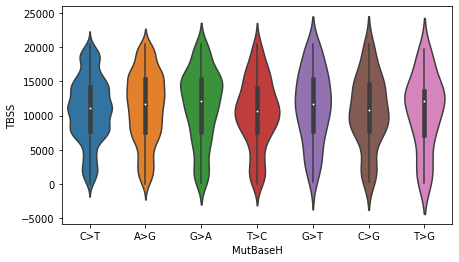

In [68]:
plt.figure(figsize=(7, 4))
sns.violinplot(data=mut, x="MutBaseH", y="TBSS", order=sbs_sample);

In [121]:
# for sbs_h in mut.MutBaseH.unique():
#     sbs_h_styled = sbs_h[0] + "h>" + sbs_h[-1] + "h"
#     mut[f"#{sbs_h_styled}"] = (mut["MutBaseH"] == sbs_h).astype(np.int8)
# mut.head()

In [230]:
window = 300
data = []
for pmin in tqdm.tqdm(range(6000, 16000-window)):
    pmax = pmin + window
    exp_sbs12, _ = get_exp_mut_freqs(pmin, pmax, Ref.dropna(subset="Nuc"), "all", verbose=False)
    if not exp_sbs12:
        continue
    obs_sbs = mut[(mut.Pos >= pmin) & (mut.Pos < pmax)]
    if not len(obs_sbs):
        continue
    one_mutspec = calculate_mutspec(obs_sbs, exp_sbs12)
    for sbs, cnt in one_mutspec.set_index("Mut").MutSpec.to_dict().items():
        row = {"Pos": pmin, "Mut": sbs, "MutSpec":cnt}
        data.append(row)

interval_counts = pd.DataFrame(data)
# interval_counts["Mut"] = interval_counts["Mut"].str.translate(translator)
print(interval_counts.shape)
interval_counts.head()

100%|██████████| 9700/9700 [01:14<00:00, 129.93it/s]


(116400, 3)


,Pos,Mut,MutSpec
0,6000,T>C,0.080230
1,6000,T>A,0.016046
2,6000,G>T,0.012461
3,6000,G>A,0.093460
4,6000,C>T,0.470637


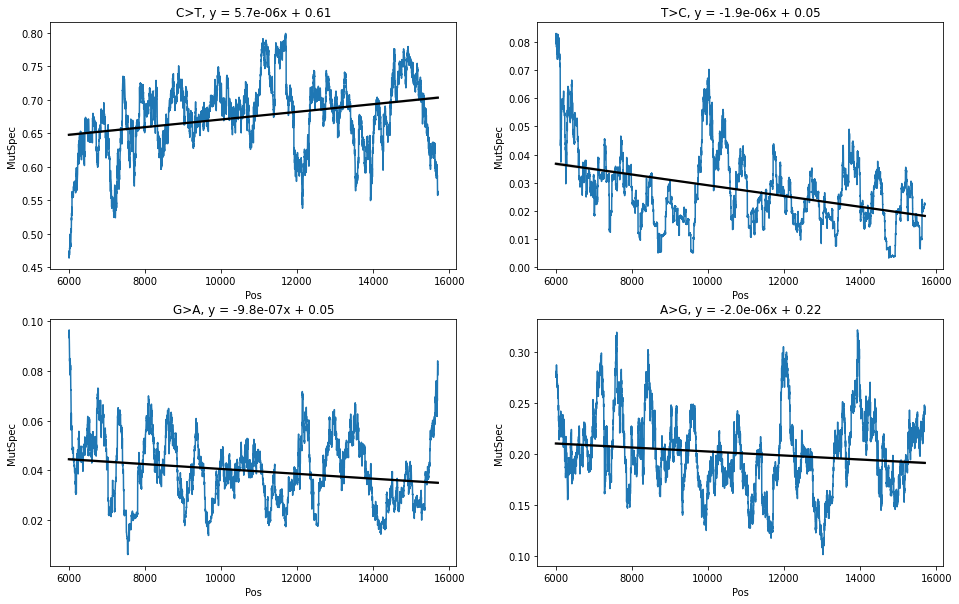

In [238]:
used_sbs = "C>T T>C G>A A>G".split()

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16, 10)

axes_dict = {
    used_sbs[0]: axs[0, 0],
    used_sbs[1]: axs[0, 1],
    used_sbs[2]: axs[1, 0],
    used_sbs[3]: axs[1, 1],
}
for sbs, ax in axes_dict.items():
    sns.lineplot(data=interval_counts[interval_counts.Mut == sbs], x="Pos", y="MutSpec", ax=ax)
    sns.regplot(data=interval_counts[interval_counts.Mut == sbs], x="Pos", y="MutSpec", ax=ax, scatter=False, color="black")
    lr_res = scipy.stats.linregress(interval_counts[interval_counts.Mut == sbs].Pos.values, interval_counts[interval_counts.Mut == sbs].MutSpec.values)
    ax.title.set_text(f"{sbs}, y = {lr_res.slope:.1e}x + {lr_res.intercept:.2f}")


In [265]:
https://seaborn.pydata.org/examples/logistic_regression.html

!!!!

SyntaxError: invalid syntax (3563348473.py, line 1)

### Tissues

In [244]:
mut.tissue.value_counts()

Liver              1273
Pancreas            861
Kidney              822
Prostate            739
Breast              689
Esophagus           409
Ovary               402
Lymphoid            316
Lung                268
CNS                 262
Colon/Rectum        224
Skin                217
Stomach             210
Thyroid             168
Bone/SoftTissue     155
Head/Neck           146
Uterus              145
Bladder              99
Biliary              90
Myeloid              78
Cervix               38
Name: tissue, dtype: int64

In [332]:
exp_sbs12, _ = coda.collect_exp_mut_freqs(Ref.dropna(subset="Nuc").sort_values("Pos").Nuc.values, ["all"])
exp_sbs12 = exp_sbs12["all"]
used_tissues = [
    'Liver', 'Pancreas', 'Kidney', 'Prostate', 'Breast', 'Esophagus',
    'Lymphoid', 'Colon/Rectum', 'Skin', 'Stomach',
    'Thyroid', 'Bone/SoftTissue', 'Head/Neck', 'Uterus', 'Bladder',
    'Biliary', 'Myeloid', 'Lung'
]

data = []
for t in used_tissues:
    obs_sbs = mut[(mut.tissue == t)]
    one_mutspec = calculate_mutspec(obs_sbs, exp_sbs12)
    for sbs, cnt in one_mutspec.set_index("Mut").MutSpec.to_dict().items():
        row = {"Tissue": t, "Mut": sbs, "MutSpec":cnt}
        data.append(row)

tissue_counts = pd.DataFrame(data)
tissue_counts["Mut"] = tissue_counts["Mut"].str.translate(translator)
print(tissue_counts.shape)
tissue_counts.head()

(216, 3)


,Tissue,Mut,MutSpec
0,Liver,T>G,0.005217
1,Liver,T>C,0.028256
2,Liver,T>A,0.005217
3,Liver,G>T,0.013328
4,Liver,G>A,0.046003


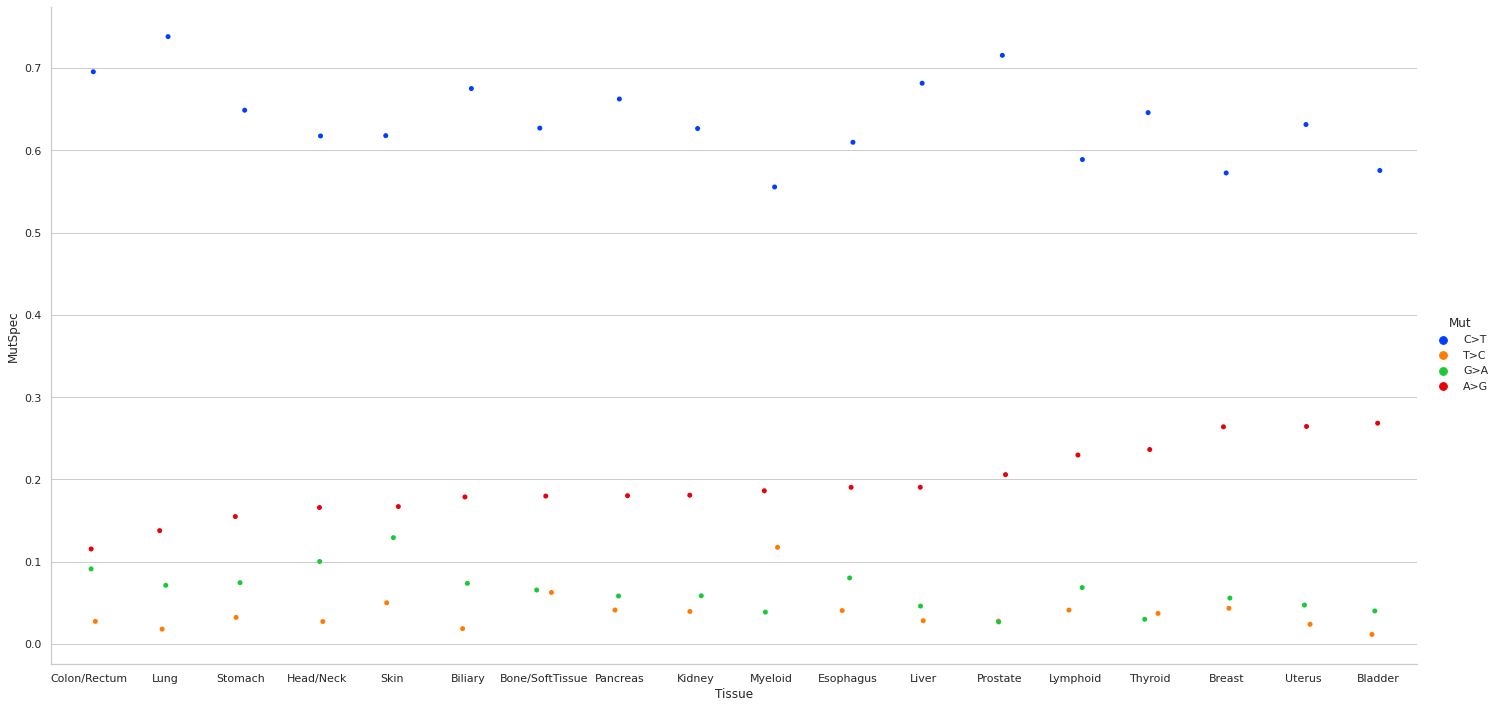

In [333]:
used_sbs = "C>T T>C G>A A>G".split()

sns.set_theme(style="whitegrid")
sns.catplot(
    data=tissue_counts, 
    x="Tissue", y="MutSpec", hue="Mut", 
    height=10, aspect=2, palette="bright", 
    order=tissue_counts.pivot("Tissue", "Mut", "MutSpec").sort_values("A>G").index,
    hue_order=used_sbs,
);

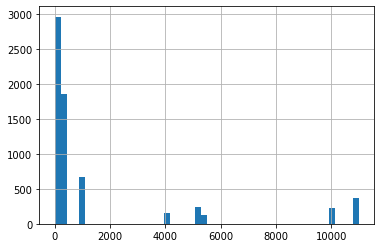

In [5]:
mut.TurnOverDays.hist(bins=50);

In [91]:
X = mut[cols[1:]]
X["DummyLowLongevity"] = (X.TurnOverDays < 2000).astype(int)
X["DummyMediumLongevity"] = ((X.TurnOverDays > 2000) & (X.TurnOverDays < 6000)).astype(int)
X["DummyHighLongevity"] = (X.TurnOverDays > 6000).astype(int)
X.drop("TurnOverDays", axis=1, inplace=True)
X.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,38.7900,10487.0,1,0,0
1,21.0500,10487.0,1,0,0
2,10.1400,426.0,1,0,0
3,37.3900,3816.0,1,0,0
4,0.7013,3816.0,1,0,0


In [92]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6595 entries, 0 to 7610
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tumor_var_freq        6595 non-null   float64
 1   TBSS                  6595 non-null   float64
 2   DummyLowLongevity     6595 non-null   int64  
 3   DummyMediumLongevity  6595 non-null   int64  
 4   DummyHighLongevity    6595 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 309.1 KB


## prepare X and Y and scale features

In [93]:
# ????????
_cols = "tumor_var_freq	TBSS".split()
scaler = StandardScaler()
scaled_fea = scaler.fit_transform(X[_cols])
X_scaled = X.copy()
X_scaled.loc[:, _cols] = scaled_fea

scaler = StandardScaler()
scaled_fea_full = scaler.fit_transform(X)
X_scaled_full = X.copy()
X_scaled_full.loc[:, :] = scaled_fea_full

In [94]:
X.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,38.7900,10487.0,1,0,0
1,21.0500,10487.0,1,0,0
2,10.1400,426.0,1,0,0
3,37.3900,3816.0,1,0,0
4,0.7013,3816.0,1,0,0


In [95]:
X_scaled.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,0.725576,-0.094186,1,0,0
1,0.082337,-0.094186,1,0,0
2,-0.313252,-2.100632,1,0,0
3,0.674813,-1.424571,1,0,0
4,-0.655492,-1.424571,1,0,0


In [96]:
X_scaled_full.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,0.725576,-0.094186,0.449612,-0.291346,-0.314325
1,0.082337,-0.094186,0.449612,-0.291346,-0.314325
2,-0.313252,-2.100632,0.449612,-0.291346,-0.314325
3,0.674813,-1.424571,0.449612,-0.291346,-0.314325
4,-0.655492,-1.424571,0.449612,-0.291346,-0.314325


### Check scaling

In [97]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X), family=sm.families.Binomial())
gamma_results = gamma_model.fit(maxiter=1000)
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Tue, 02 Aug 2022   Deviance:                       7862.6
Time:                        13:39:06   Pearson chi2:                 6.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8131 

In [98]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X_scaled_full), family=sm.families.Binomial())
gamma_results = gamma_model.fit(maxiter=1000)
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Tue, 02 Aug 2022   Deviance:                       7862.6
Time:                        13:39:10   Pearson chi2:                 6.60e+03
No. Iterations:                   575   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9227 

In [99]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X_scaled), family=sm.families.Binomial())
gamma_results = gamma_model.fit(maxiter=1000)
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Tue, 02 Aug 2022   Deviance:                       7862.6
Time:                        13:39:14   Pearson chi2:                 6.60e+03
No. Iterations:                   366   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6700 

## GLM on all mutations

In [100]:
glm_data = []
for sbs in mut.columns[4:]:
    Y = mut[[sbs]]
    gamma_model = sm.GLM(Y, sm.add_constant(X_scaled), family=sm.families.Binomial())
    gamma_results = gamma_model.fit(maxiter=1000)
    one_data = {"mutation": sbs.replace("Dummy", "")}
    for fea in gamma_results.params.index:
        if gamma_results.pvalues[fea] < 0.05:
            one_data[fea] = gamma_results.params[fea]
        one_data[fea + "-pval"] = gamma_results.pvalues[fea]

    glm_data.append(one_data)

In [101]:
df = pd.DataFrame(glm_data)
df[["mutation"] + list(X.columns)].to_csv("../data/processed/glm_output_scaled_significant.ccsv", index=None)
df[["mutation"] + list(X.columns)].round(3)

,mutation,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,Ah>Gh,0.073,0.065,-0.265,-0.363,NaN
1,Ch>Th,NaN,NaN,NaN,0.182,-0.129
2,Th>Ch,NaN,NaN,-0.746,-0.787,-0.622
3,Th>Gh,NaN,NaN,-1.372,-1.145,-0.637
4,Ch>Gh,NaN,NaN,-1.074,-1.118,-0.843
5,Gh>Ah,NaN,NaN,NaN,NaN,NaN
6,Ah>Th,NaN,NaN,NaN,NaN,NaN
7,Gh>Th,-0.422,NaN,-0.620,-1.380,-1.310
8,Ah>Ch,NaN,NaN,-1.834,-1.334,-1.052
9,Ch>Ah,NaN,NaN,-1.497,-1.197,-1.306


In [102]:
df

,mutation,const,const-pval,tumor_var_freq,tumor_var_freq-pval,TBSS,TBSS-pval,DummyLowLongevity,DummyLowLongevity-pval,DummyMediumLongevity,DummyMediumLongevity-pval,DummyHighLongevity-pval,DummyHighLongevity
0,Ah>Gh,-0.669997,4.635777e-86,0.072640,0.006485,0.064646,0.018420,-0.265056,3.992508e-11,-0.363206,3.702827e-06,0.554036,NaN
1,Ch>Th,0.068469,2.721712e-02,NaN,0.579585,NaN,0.062793,NaN,6.653678e-01,0.181977,9.324462e-03,0.049845,-0.129267
2,Th>Ch,-2.154749,1.339461e-217,NaN,0.434359,NaN,0.083822,-0.746430,2.249050e-20,-0.786511,6.292500e-07,0.000010,-0.621808
3,Th>Gh,-3.154200,1.962282e-144,NaN,0.161080,NaN,0.461108,-1.371937,4.105672e-19,-1.144855,1.088453e-04,0.006283,-0.637408
4,Ch>Gh,-3.034532,3.464473e-145,NaN,0.818742,NaN,0.445200,-1.074040,2.040947e-14,-1.117796,5.912588e-05,0.000396,-0.842696
5,Gh>Ah,NaN,7.914819e-01,NaN,0.973544,NaN,0.052045,NaN,7.914819e-01,NaN,7.914819e-01,0.791482,NaN
6,Ah>Th,NaN,9.999839e-01,NaN,0.349281,NaN,0.498600,NaN,9.999900e-01,NaN,9.999880e-01,0.999990,NaN
7,Gh>Th,-3.309885,2.768688e-99,-0.421765,0.001512,NaN,0.327028,-0.619538,2.355994e-04,-1.379849,9.458366e-05,0.000067,-1.310498
8,Ah>Ch,-4.220780,2.098459e-69,NaN,0.594888,NaN,0.843610,-1.834472,3.272994e-09,-1.333927,1.627579e-02,0.026457,-1.052381
9,Ch>Ah,-4.000181,1.313670e-76,NaN,0.255833,NaN,0.149067,-1.496945,5.822415e-09,-1.196790,9.448090e-03,0.004570,-1.306446
